# Mask Research


In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import gc
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [5]:
data_path = '../../data/siim-pneumothorax'
mask_path = os.path.join(data_path, 'mask_png')

mask_list = os.listdir(mask_path)
mask_list = filter(lambda filename: len(os.path.splitext(filename))>1 and (os.path.splitext(filename)[1]=='.png'), mask_list)
mask_list = [os.path.join(mask_path, mask_name) for mask_name in mask_list]


### 研究Mask面积分布

In [6]:
def calc_mask_area(mask_file):
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.
    return mask.sum()

pool = mp.Pool()
areas = pool.map(calc_mask_area, mask_list)


In [24]:
pos_areas = list(filter(lambda area: (area > 0), areas))

print('total: {}, max area: {}, min area: {}'.format(len(pos_areas), np.max(pos_areas), np.min(pos_areas)))


total: 2379, max area: 161421.0, min area: 55.0


(array([611., 540., 340., 199., 166., 108.,  84.,  75.,  59.,  44.,  23.,
         22.,  14.,  22.,  10.,  11.,   5.,   7.,   7.,   7.,   6.,   1.,
          2.,   3.,   2.,   3.,   1.,   0.,   1.,   2.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([5.5000000e+01, 4.0891499e+03, 8.1232998e+03, 1.2157450e+04,
        1.6191600e+04, 2.0225750e+04, 2.4259900e+04, 2.8294051e+04,
        3.2328199e+04, 3.6362352e+04, 4.0396500e+04, 4.4430648e+04,
        4.8464801e+04, 5.2498949e+04, 5.6533102e+04, 6.0567250e+04,
        6.4601398e+04, 6.8635547e+04, 7.2669703e+04, 7.6703852e+04,
        8.0738000e+04, 8.4772148e+04, 8.8806297e+04, 9.2840453e+04,
        9.6874602e+04, 1.0090875e+05, 1.0494290e+05, 1.0897705e+05,
        1.1301120e+05, 1.1704535e+05, 1.2107950e+05, 1.2511365e+05,
        1.2914780e+05, 1.3318195e+05, 1.3721609e+05, 1.4125025e+05,
        1.4528441e+05, 1.4931855e+05, 1.5335270e+05, 1.5738684e+05,
        1.6142100e+05], dtype=float32),
 <a li

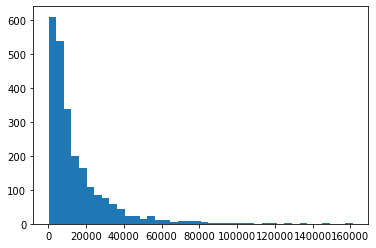

In [10]:
plt.hist(pos_areas, bins=40)

### 研究无Noise Removal的预测面积分布

In [32]:
nfolds = 4

tag = '20190729-122311_512'
self_attention = True

best_thr = 0.565

In [33]:
p_areas = []

for fold in range(nfolds):
    print('fold: ', fold)
    
    # load preds and ys
    preds = torch.load('hc_preds_{}_fold{}.pth'.format(tag, fold))
    # ys = torch.load('hc_ys_{}_fold{}.pth'.format(tag, fold))
    
    preds_m = (preds>best_thr).long()
    
    n = preds_m.shape[0]
    pred_areas = preds_m.view(n, -1).sum(-1)
    p_areas.append(pred_areas)
    
    del preds
    gc.collect()
    torch.cuda.empty_cache()
    
p_areas = torch.cat(p_areas, dim=0)
print(p_areas.shape)

fold:  0
fold:  1
fold:  2
fold:  3
torch.Size([10712])


In [34]:
ppos_areas = list(filter(lambda p_area: (p_area>0), p_areas.numpy()))

print('total: {}, max area: {}, min area: {}'.format(len(ppos_areas), np.max(ppos_areas), np.min(ppos_areas)))

total: 1801, max area: 30849, min area: 1


(array([745., 305., 170., 123.,  88.,  74.,  59.,  55.,  45.,  20.,  18.,
         19.,   7.,  15.,   5.,  13.,   1.,   9.,   4.,   3.,   2.,   3.,
          5.,   1.,   0.,   0.,   1.,   2.,   2.,   0.,   0.,   0.,   1.,
          0.,   0.,   2.,   1.,   0.,   1.,   2.]),
 array([1.00000e+00, 7.72200e+02, 1.54340e+03, 2.31460e+03, 3.08580e+03,
        3.85700e+03, 4.62820e+03, 5.39940e+03, 6.17060e+03, 6.94180e+03,
        7.71300e+03, 8.48420e+03, 9.25540e+03, 1.00266e+04, 1.07978e+04,
        1.15690e+04, 1.23402e+04, 1.31114e+04, 1.38826e+04, 1.46538e+04,
        1.54250e+04, 1.61962e+04, 1.69674e+04, 1.77386e+04, 1.85098e+04,
        1.92810e+04, 2.00522e+04, 2.08234e+04, 2.15946e+04, 2.23658e+04,
        2.31370e+04, 2.39082e+04, 2.46794e+04, 2.54506e+04, 2.62218e+04,
        2.69930e+04, 2.77642e+04, 2.85354e+04, 2.93066e+04, 3.00778e+04,
        3.08490e+04]),
 <a list of 40 Patch objects>)

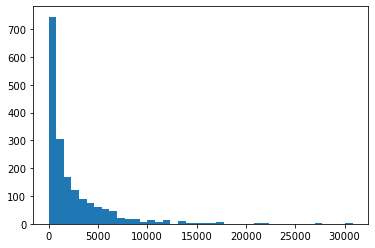

In [35]:
plt.hist(ppos_areas, bins=40)

In [36]:
print('total area: {}'.format(np.sum(ppos_areas)))

total area: 4339143


## 有Noise Removal的预测分布

In [27]:
nfolds = 4

tag = '20190729-122311_512'
self_attention = True

sz = 512
noise_th = 75.0*(sz/128.0)**2
best_thr = 0.255

In [28]:
p_areas = []

for fold in range(nfolds):
    print('fold: ', fold)
    
    # load preds and ys
    preds = torch.load('hc_preds_{}_fold{}.pth'.format(tag, fold))
    # ys = torch.load('hc_ys_{}_fold{}.pth'.format(tag, fold))
    
    preds[preds.view(preds.shape[0],-1).sum(-1) < noise_th,...] = 0.0
    
    preds_m = (preds>best_thr).long()
    
    n = preds_m.shape[0]
    pred_areas = preds_m.view(n, -1).sum(-1)
    p_areas.append(pred_areas)
    
    del preds
    gc.collect()
    torch.cuda.empty_cache()
    
p_areas = torch.cat(p_areas, dim=0)
print(p_areas.shape)

fold:  0
fold:  1
fold:  2
fold:  3
torch.Size([10712])


In [29]:
ppos_areas = list(filter(lambda p_area: (p_area>0), p_areas.numpy()))

print('total: {}, max area: {}, min area: {}'.format(len(ppos_areas), np.max(ppos_areas), np.min(ppos_areas)))

total: 1443, max area: 39024, min area: 176


(array([ 36., 272., 313., 177., 116., 119.,  75.,  80.,  58.,  43.,  28.,
         24.,  19.,   8.,  12.,  12.,   6.,   5.,   6.,   2.,   6.,   4.,
          5.,   1.,   5.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,
          1.,   0.,   1.,   2.,   1.,   0.,   1.]),
 array([  176. ,  1147.2,  2118.4,  3089.6,  4060.8,  5032. ,  6003.2,
         6974.4,  7945.6,  8916.8,  9888. , 10859.2, 11830.4, 12801.6,
        13772.8, 14744. , 15715.2, 16686.4, 17657.6, 18628.8, 19600. ,
        20571.2, 21542.4, 22513.6, 23484.8, 24456. , 25427.2, 26398.4,
        27369.6, 28340.8, 29312. , 30283.2, 31254.4, 32225.6, 33196.8,
        34168. , 35139.2, 36110.4, 37081.6, 38052.8, 39024. ]),
 <a list of 40 Patch objects>)

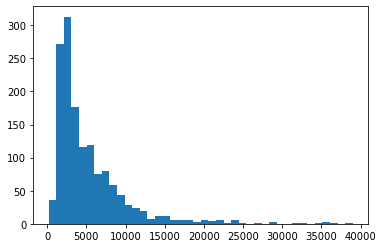

In [30]:
plt.hist(ppos_areas, bins=40)

In [31]:
print('total area: {}'.format(np.sum(ppos_areas)))

total area: 7473049


## 小面积预测分布

In [6]:
nfolds = 4

tag = '20190729-122311_512'
self_attention = True

sz = 512
noise_th = 75.0*(sz/128.0)**2
best_thr = 0.815

In [7]:
p_areas = []

for fold in range(nfolds):
    print('fold: ', fold)
    
    # load preds and ys
    preds = torch.load('hc_preds_{}_fold{}.pth'.format(tag, fold))
    # ys = torch.load('hc_ys_{}_fold{}.pth'.format(tag, fold))
    
    mask = preds.view(preds.shape[0],-1).sum(-1) < noise_th
    indices = mask.nonzero().squeeze(1)

    preds = preds[indices]
    
    preds_m = (preds>best_thr).long()
    
    n = preds_m.shape[0]
    pred_areas = preds_m.view(n, -1).sum(-1)
    p_areas.append(pred_areas)
    
    del preds
    gc.collect()
    torch.cuda.empty_cache()
    
p_areas = torch.cat(p_areas, dim=0)
print(p_areas.shape)

fold:  0
fold:  1
fold:  2
fold:  3
torch.Size([9269])


In [8]:
ppos_areas = list(filter(lambda p_area: (p_area>0), p_areas.numpy()))

print('total: {}, max area: {}, min area: {}'.format(len(ppos_areas), np.max(ppos_areas), np.min(ppos_areas)))

total: 82, max area: 519, min area: 2


(array([13., 16., 10.,  7.,  7.,  3.,  2.,  3.,  2.,  3.,  2.,  0.,  1.,
         1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,
         1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([  2.   ,  14.925,  27.85 ,  40.775,  53.7  ,  66.625,  79.55 ,
         92.475, 105.4  , 118.325, 131.25 , 144.175, 157.1  , 170.025,
        182.95 , 195.875, 208.8  , 221.725, 234.65 , 247.575, 260.5  ,
        273.425, 286.35 , 299.275, 312.2  , 325.125, 338.05 , 350.975,
        363.9  , 376.825, 389.75 , 402.675, 415.6  , 428.525, 441.45 ,
        454.375, 467.3  , 480.225, 493.15 , 506.075, 519.   ]),
 <a list of 40 Patch objects>)

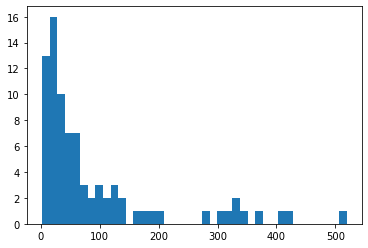

In [9]:
plt.hist(ppos_areas, bins=40)